# Importing the required modules.

In [1]:
# Modules required for data handling and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid")

# Modules required for accessing the file system.
import os

# Modules used for model training and transfer learning
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as cnns
from tensorflow.keras import Model

# Modules used for model evaluation and selection.
from sklearn.metrics import accuracy_score, classification_report, f1_score


# Disabling logging
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Constants
TRAIN_CSV_DIR = "/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv"
TEST_CSV_DIR = "/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv"
VAL_CSV_DIR = "/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv"

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.debugging.set_log_device_placement(False)

# Exploratory Data Analysis

Since, there are too many classes there is a chance of class imbalance to verify it we analyse the class distribution.

In [4]:
train_labels = pd.read_csv(TRAIN_CSV_DIR)
test_labels = pd.read_csv(TEST_CSV_DIR)
val_labels = pd.read_csv(VAL_CSV_DIR)

In [5]:
train_labels.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


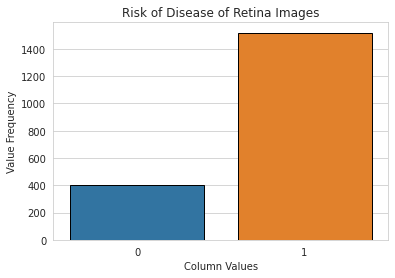

In [6]:
disease_risk_col = dict(train_labels["Disease_Risk"].value_counts())
col_labels = list(disease_risk_col.keys())
label_freq = list(disease_risk_col.values())
sns.barplot(x = col_labels,
            y = label_freq,
            edgecolor = "black")
plt.title("Risk of Disease of Retina Images")
plt.xlabel("Column Values")
plt.ylabel("Value Frequency")
plt.show()

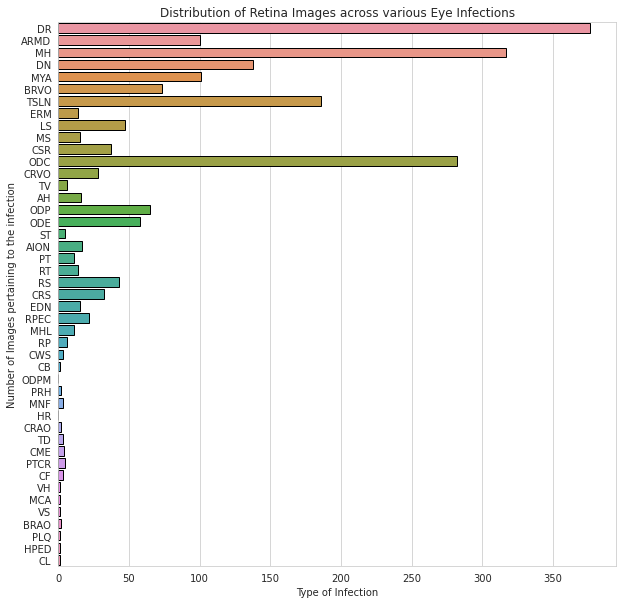

In [7]:
infected_retinas = dict(train_labels.drop(["ID", "Disease_Risk"], axis=1).sum())
retina_infections = list(infected_retinas.keys())
infection_freq = list(infected_retinas.values())
plt.figure(figsize = (10,10))
sns.barplot(y = retina_infections,
            x = infection_freq,
            edgecolor = "black",
            orient = "h")
plt.title("Distribution of Retina Images across various Eye Infections")
plt.xlabel("Type of Infection")
plt.ylabel("Number of Images pertaining to the infection")
plt.show()

From the class distribution we can make the following inferences:
- The diseases OPDM and HR have no samples for training and hence will be dropped. 
- The aim of the model is to predict different diseases so for multilabel classification, Disease Risk column is not relevant. However, we can built a binary classifier for predicting whether the retinal image poses a risk of any disease or not. Based on the outcome of the binary classifier, we will use the multilabel classifier.
- We also observe that there is a lot of class imbalance and hence, for classes below a certain threshold we will consider them into a category of "Other" category.

# Training a binary classifier for Disease Risk Feature

In [8]:
TRAIN_IMG_DIR="/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training"
TEST_IMG_DIR = "/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test"
VAL_IMG_DIR = "/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation"
def id_to_path(id : int, IMG_DIR : str):
    return os.path.join(IMG_DIR, str(id) + ".png")

In [9]:
train_labels["IMG_DIR"] = TRAIN_IMG_DIR
train_labels["IMG_DIR"] = train_labels.apply(lambda x: id_to_path(x.ID, x.IMG_DIR), 
                                             axis=1)
test_labels["IMG_DIR"] = TEST_IMG_DIR
test_labels["IMG_DIR"] = test_labels.apply(lambda x: id_to_path(x.ID, x.IMG_DIR), 
                                           axis=1)
val_labels["IMG_DIR"] = VAL_IMG_DIR
val_labels["IMG_DIR"] = val_labels.apply(lambda x: id_to_path(x.ID, x.IMG_DIR), 
                                         axis=1)

In [10]:
class ImagePreprocessor:
    def __init__(self, cnn_variant):
        self.cnn_variant = cnn_variant
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None
        
    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input,
        )

        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )

        self.val_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )
        
    def preprocess(self):
        train_images = self.train_gen.flow_from_dataframe(
              train_labels,
              x_col="IMG_DIR", 
              y_col="Disease_Risk",
              target_size=(200,200),
              color_mode='rgb',
              batch_size=32,
              class_mode="binary",
              shuffle=False
        )

        val_images = self.val_gen.flow_from_dataframe(
              test_labels,
              x_col="IMG_DIR", 
              y_col="Disease_Risk",
              target_size=(200,200),
              color_mode='rgb',
              batch_size=32,
              class_mode="binary",
              shuffle=False
        )

        test_images = self.test_gen.flow_from_dataframe(
              val_labels,
              x_col="IMG_DIR", 
              y_col="Disease_Risk",
              color_mode='rgb',
              target_size=(200,200),
              batch_size=32,
              class_mode="binary",
              shuffle=False
        )

        return train_images, val_images, test_images

In [11]:
train_labels["Disease_Risk"] = train_labels["Disease_Risk"].astype(str)
test_labels["Disease_Risk"] = test_labels["Disease_Risk"].astype(str)
val_labels["Disease_Risk"] = val_labels["Disease_Risk"].astype(str)

In [12]:
class TransferLearning:

    def __init__(self, train, val, model) -> None:
        self.train = train
        self.val = val
        self.model = model
        self.history = None
        self.fine_tune_from = 100
        self.INPUT_SIZE = (200,200,3)
    
    def mark_layers_non_trainable(self):
        for layer in self.model.layers[:self.fine_tune_from]:
            layer.trainable = False
        
        for layer in self.model.layers[self.fine_tune_from:]:
            layer.trainable = True
    
    def add_final_layer(self):
        self.x = Flatten()(self.model.output)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(1, activation = 'sigmoid')(self.x)

    def compile_model(self):
        self.model = Model(inputs = self.model.input, 
                           outputs = self.predictions)
        self.model.compile(optimizer='adam', 
                           loss="binary_crossentropy", 
                           metrics=['accuracy',
                                    tf.keras.metrics.AUC(name="auc",from_logits=True),
                                    tf.keras.metrics.FalseNegatives(name="false_negatives"),
                                    tf.keras.metrics.FalsePositives(name="false_positives"),
                                    tf.keras.metrics.Precision(name="precision"),
                                    tf.keras.metrics.Recall(name="recall")])
    
    def train_model(self):
        self.history = self.model.fit(self.train,
                                      batch_size=32, 
                                      epochs=100, 
                                      validation_data=self.val,
                                      callbacks=[
                                        tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True
                                        )
                                     ])

In [13]:
def experiment_model(preprocessing_function, model):
    preprocessor = ImagePreprocessor(preprocessing_function)
    preprocessor.create_generators()
    train, val, test = preprocessor.preprocess()
    modelbuilder = TransferLearning(train, val, model)
    modelbuilder.mark_layers_non_trainable()
    modelbuilder.add_final_layer()
    modelbuilder.compile_model()
    modelbuilder.train_model()
    return modelbuilder.model, modelbuilder.history, test

In [17]:
class ModelEvaluator:
    def __init__(self, history, classes : list, model, test):
        self.history = history
        self.model = model
        self.test = test
        self.classes = classes
        self.num_classes = len(self.classes)
        self.predictions = None
        self.t = 0.5
    
    def __plot_metric(self, ax, metric: str,train_metric : str, val_metric : str):
        
        ax.plot(self.history.history[train_metric])
        ax.plot(self.history.history[val_metric])
        ax.title.set_text(train_metric + " v/s " + val_metric)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.title())
        ax.legend(['Train','Val'])
    
    def training_history(self):
        rows = 4
        columns = 2
        c = 0
        metrics = ["loss", "accuracy", "auc", "false_negatives", "false_positives", "precision", "recall"]
        fig, axs = plt.subplots(rows, columns,figsize=(15,15))
        for metric in metrics:
            self.__plot_metric(axs[c//columns, c%columns], 
                               metric.replace("_", " ").title(), 
                               metric, "val_"+metric)
            c += 1
        fig.suptitle("Training History of the Model")
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)
        plt.show()
    
    def __clip_sigmoid_output(self, p : float):
        if p >= self.t:
            return 1
        else:
            return 0
    
    def predict(self):
        self.predictions = self.model.predict(self.test).flatten()
        self.predictions = list(map(self.__clip_sigmoid_output, self.predictions))
    
    def class_report(self):
        sns.heatmap(tf.math.confusion_matrix(self.test.labels, self.predictions, num_classes=2), 
                    annot=True, cmap="crest")
        print(classification_report(self.test.labels, self.predictions, target_names=self.classes))

In [29]:
class ThresholdTuner:
    def __init__(self, model, test):
        self.model = model
        self.test = test
        self.predictions_raw = None
        self.f1_scores = []
    
    def __predict_test(self):
        self.predictions_raw = self.model.predict(self.test).flatten()
    
    def __clip_logits(self, t : float, p : float):
        if p >= t:
            return 1
        else:
            return 0
    
    def tune_threshold(self):
        self.__predict_test()
        self.ts = np.arange(0, 1.0, 0.001)
        for threshold in self.ts:
            pred = list(map(lambda p: self.__clip_logits(threshold, p), 
                            self.predictions_raw))
            self.f1_scores.append(f1_score(self.test.labels, pred))
        
        plt.plot(self.ts, self.f1_scores)
        max_f1_score = max(self.f1_scores)
        max_threshold = self.ts[np.argmax(self.f1_scores)]
        plt.plot(max_threshold, max_f1_score, 'ro')
        plt.plot(0.50, self.f1_scores[500], 'go')
        plt.text(max_threshold, max_f1_score+0.1, '({}, {})'.format(max_threshold, max_f1_score))
        plt.title("Tuning of the Threshold")
        plt.xlabel("Threshold Value")
        plt.ylabel("F1 score")
        plt.show()

# Experimentation of models for Binary Classification

## EfficientNetB4

In [31]:
efficientnet, history, efficientnet_test = experiment_model(cnns.efficientnet, 
                                                    cnns.efficientnet.EfficientNetB4(include_top=False, 
                                                    input_shape=(200,200,3)))

Found 1920 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Epoch 1/100
60/60 [==============================] - 335s 5s/step - loss: 3.3762 - accuracy: 0.7656 - auc: 0.6557 - false_negatives: 63.0000 - false_positives: 387.0000 - precision: 0.7900 - recall: 0.9585 - val_loss: 0.7282 - val_accuracy: 0.7906 - val_auc: 0.8544 - val_false_negatives: 0.0000e+00 - val_false_positives: 134.0000 - val_precision: 0.7906 - val_recall: 1.0000
Epoch 2/100
60/60 [==============================] - 302s 5s/step - loss: 0.4450 - accuracy: 0.7911 - auc: 0.7703 - false_negatives: 0.0000e+00 - false_positives: 401.0000 - precision: 0.7911 - recall: 1.0000 - val_loss: 0.3873 - val_accuracy: 0.7906 - val_auc: 0.9331 - val_false_negatives: 0.0000e+00 - val_false_positives: 134.0000 - val_precision: 0.7906 - val_recall: 1.0000
Epoch 3/100
60/60 [==============================] - 296s 5s/s

In [32]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], efficientnet, efficientnet_test)

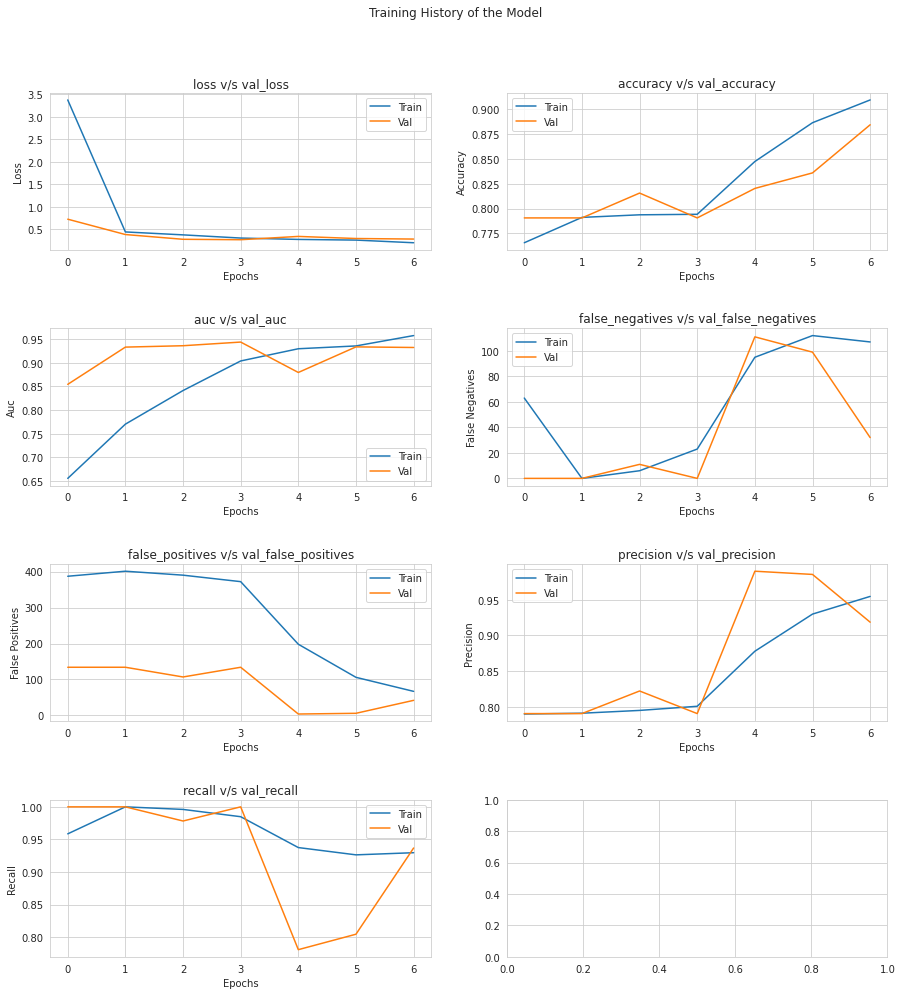

In [33]:
me.training_history()
me.predict()

              precision    recall  f1-score   support

Not Infected       0.00      0.00      0.00       134
    Infected       0.79      1.00      0.88       506

    accuracy                           0.79       640
   macro avg       0.40      0.50      0.44       640
weighted avg       0.63      0.79      0.70       640



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


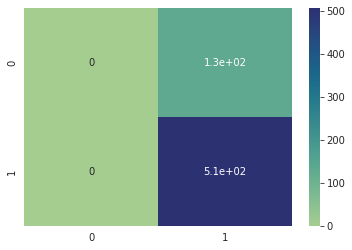

In [34]:
me.class_report()

In [64]:
tuner = ThresholdTuner(efficientnet, efficientnet_test)

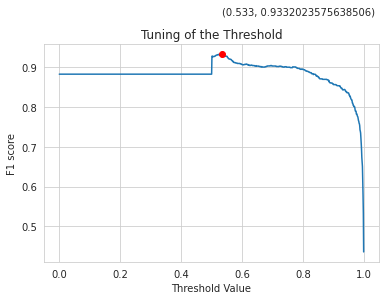

In [65]:
tuner.tune_threshold()

In [52]:
print(tuner.ts[np.argmax(tuner.f1_scores)], max(tuner.f1_scores))

0.533 0.9332023575638506


In [25]:
def clip_predictions(x):
    if x > 0.533:
        return 1
    else:
        return 0

In [26]:
p = list(map(clip_predictions, tuner.predictions_raw))

In [27]:
print(classification_report(efficientnet_test.labels, p, target_names=["Not Infected", "Infected"]))

              precision    recall  f1-score   support

Not Infected       0.71      0.63      0.67       134
    Infected       0.91      0.93      0.92       506

    accuracy                           0.87       640
   macro avg       0.81      0.78      0.80       640
weighted avg       0.87      0.87      0.87       640



## EfficientNetB5

In [15]:
efficientnet, history, efficientnet_test = experiment_model(cnns.efficientnet, 
                                                    cnns.efficientnet.EfficientNetB5(include_top=False, 
                                                    input_shape=(200,200,3)))

Found 1920 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Epoch 1/100
60/60 [==============================] - 328s 5s/step - loss: 1.6177 - accuracy: 0.7880 - auc: 0.6734 - false_negatives: 27.0000 - false_positives: 380.0000 - precision: 0.7970 - recall: 0.9822 - val_loss: 0.4023 - val_accuracy: 0.7906 - val_auc: 0.8774 - val_false_negatives: 0.0000e+00 - val_false_positives: 134.0000 - val_precision: 0.7906 - val_recall: 1.0000
Epoch 2/100
60/60 [==============================] - 313s 5s/step - loss: 0.4216 - accuracy: 0.7911 - auc: 0.7822 - false_negatives: 0.0000e+00 - false_positives: 401.0000 - precision: 0.7911 - recall: 1.0000 - val_loss: 0.3281 - val_accuracy: 0.7906 - val_auc: 0.9365 - val_false_negatives: 0.0000e+00 - val_false_positives: 134.0000 - val_precision: 0.7906 - val_recall: 1.0000
Epoch 3/100
60/60 [==============================] - 306s 5s/s

In [19]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], efficientnet, efficientnet_test)

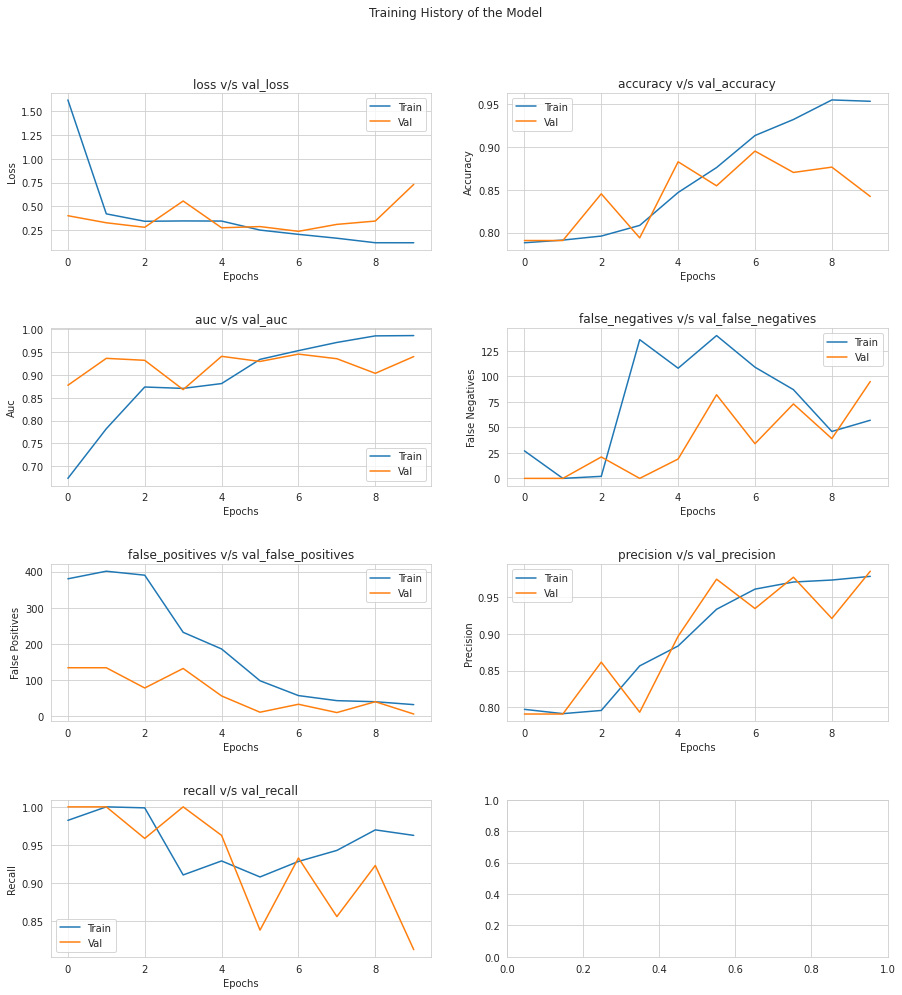

In [20]:
me.training_history()
me.predict()

              precision    recall  f1-score   support

Not Infected       0.73      0.62      0.67       134
    Infected       0.90      0.94      0.92       506

    accuracy                           0.87       640
   macro avg       0.82      0.78      0.79       640
weighted avg       0.87      0.87      0.87       640



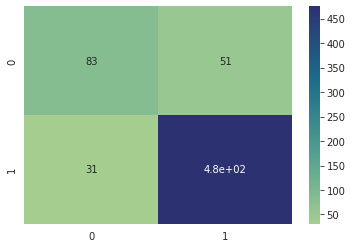

In [21]:
me.class_report()

In [31]:
tuner = ThresholdTuner(efficientnet, efficientnet_test)

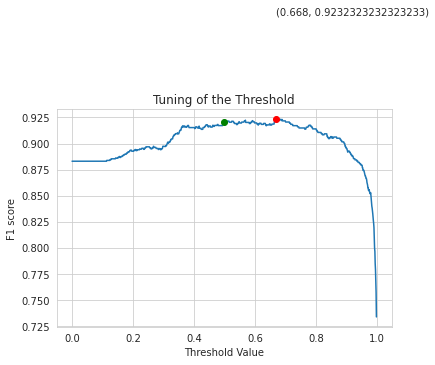

In [32]:
tuner.tune_threshold()

In [33]:
print(tuner.ts[np.argmax(tuner.f1_scores)], max(tuner.f1_scores))

0.668 0.9232323232323233
